# Working with time in `xarray`

**Notebook currently compatible with both `NCI` and `DEA Sandbox` environments**

### Description
The `xarray` package provides many useful techniques for dealing with time series data that can be applied to Digital Earth Australia data. 
This notebook demonstrates how to use `xarray` techniques to:

* Select different time periods of data (e.g. year, month, day) from an `xarray.Dataset`
* Using datetime accessors to extract additional information from a dataset's `time` dimension
* Summarising time series data for different time periods using `.groupby()` and `.resample()`
* Interpolating time series data to estimate landscape conditions at a specific date that the satellite did not observe

For additional information about the techniques demonstrated below, refer to the `xarray` [Time series data guide](http://xarray.pydata.org/en/stable/time-series.html). 


### Technical details
* **Products used:** 
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3/2016)
* **Analyses used:** extracting time series data, indexing by time, grouping and resampling by time, interpolating new time steps

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt


### Connect to the datacube


In [2]:
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc = datacube.Datacube(app='Using_load_ard', env='c3-samples')
except:
    dc = datacube.Datacube(app='Using_load_ard')


## Loading Landsat data
First, we load in a two years of Landsat 8 data, and apply a simple cloud mask:

In [3]:
# Set up a location for the analysis
query = {
    'x': (142.41, 142.51),
    'y': (-32.22, -32.32),
    'time': ('2015-01-01', '2016-12-31'),
    'measurements': ['nbart_nir', 'fmask'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30)
}

# Load Landsat 8 data
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)

# Apply simple cloud mask (keep only clear, water or snow observations)
ds = ds.where(ds.fmask.isin([1, 4, 5]))

print(ds)


<xarray.Dataset>
Dimensions:    (time: 46, x: 342, y: 398)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-06T00:20:26.943424 ... 2016-12-26T00:20:38.145340
  * y          (y) float64 -3.552e+06 -3.552e+06 ... -3.563e+06 -3.563e+06
  * x          (x) float64 9.709e+05 9.71e+05 9.71e+05 ... 9.811e+05 9.812e+05
Data variables:
    nbart_nir  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    fmask      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577


## Working with time
### Indexing by time
We can extract data for an entire year by passing a string to `.sel()`:

In [4]:
ds.sel(time='2015')


<xarray.Dataset>
Dimensions:    (time: 23, x: 342, y: 398)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-06T00:20:26.943424 ... 2015-12-24T00:20:32.375097
  * y          (y) float64 -3.552e+06 -3.552e+06 ... -3.563e+06 -3.563e+06
  * x          (x) float64 9.709e+05 9.71e+05 9.71e+05 ... 9.811e+05 9.812e+05
Data variables:
    nbart_nir  (time, y, x) float64 nan nan nan ... 3.123e+03 3.148e+03
    fmask      (time, y, x) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

Or extract a single month:

In [5]:
ds.sel(time='2015-05')


<xarray.Dataset>
Dimensions:    (time: 2, x: 342, y: 398)
Coordinates:
  * time       (time) datetime64[ns] 2015-05-14T00:19:24.695756 2015-05-30T00:19:28.951301
  * y          (y) float64 -3.552e+06 -3.552e+06 ... -3.563e+06 -3.563e+06
  * x          (x) float64 9.709e+05 9.71e+05 9.71e+05 ... 9.811e+05 9.812e+05
Data variables:
    nbart_nir  (time, y, x) float64 2.02e+03 2.276e+03 2.164e+03 ... nan nan nan
    fmask      (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

Or select a range of dates using `slice()`. This selects all observations between the two dates, inclusive of both the start and stop values:

In [6]:
ds.sel(time=slice('2015-06', '2016-01'))


<xarray.Dataset>
Dimensions:    (time: 15, x: 342, y: 398)
Coordinates:
  * time       (time) datetime64[ns] 2015-06-15T00:19:41.139454 ... 2016-01-25T00:20:28.787852
  * y          (y) float64 -3.552e+06 -3.552e+06 ... -3.563e+06 -3.563e+06
  * x          (x) float64 9.709e+05 9.71e+05 9.71e+05 ... 9.811e+05 9.812e+05
Data variables:
    nbart_nir  (time, y, x) float64 6.727e+03 nan nan ... 3.324e+03 3.307e+03
    fmask      (time, y, x) float64 1.0 nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

### Using the datetime accessor
`xarray` allows you to easily extract additional information from the `time` dimension in Digital Earth Australia data. For example, we can get a list of what season each observation belongs to:

In [7]:
ds.time.dt.season


<xarray.DataArray 'season' (time: 46)>
array(['DJF', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM',
       'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'SON', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM',
       'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'JJA', 'SON', 'SON',
       'SON', 'SON', 'SON', 'SON', 'DJF', 'DJF'], dtype='<U3')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-06T00:20:26.943424 ... 2016-12-26T00:20:38.145340

Or the day of the year:

In [8]:
ds.time.dt.dayofyear


<xarray.DataArray 'dayofyear' (time: 46)>
array([  6,  22,  38,  54,  70,  86, 102, 118, 134, 150, 166, 182, 198, 214,
       230, 246, 262, 278, 294, 310, 326, 342, 358,   9,  25,  41,  57,  73,
        89, 105, 121, 137, 153, 169, 185, 201, 217, 233, 249, 265, 281, 297,
       313, 329, 345, 361])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-06T00:20:26.943424 ... 2016-12-26T00:20:38.145340

### Grouping and resampling by time
`xarray` also provides some shortcuts for aggregating data over time. In the example below, we first group our data by season, then take the median of each group. This produces a new dataset with only four observations (one per season). 

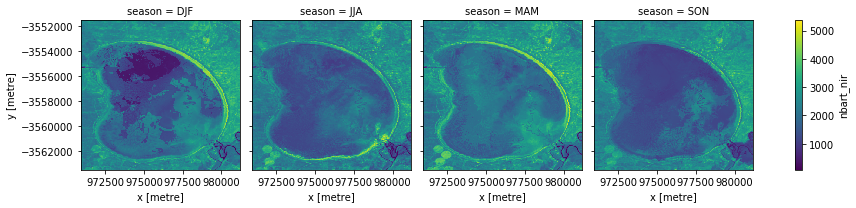

In [9]:
# Group the time series into seasons, and take median of each time period
ds_seasonal = ds.groupby('time.season').median(dim='time')

# Plot the output
ds_seasonal.nbart_nir.plot(col='season', col_wrap=4)
plt.show()


We can also use the `.resample()` method to summarise our dataset into larger chunks of time. In the example below, we produce a median composite for every 5 months of data in our dataset:

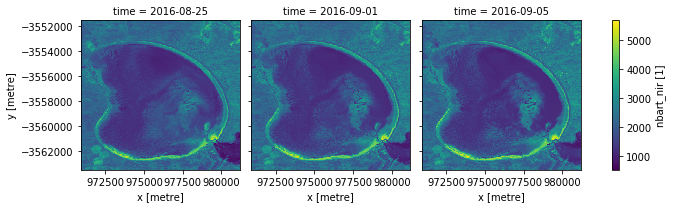

In [10]:
# New dates to interpolate data for
new_dates = ['2016-08-25', '2016-09-01', '2016-09-05']

# Interpolate Landsat values for three new dates
ds_interp = ds.interp(time=new_dates)

# Plot the new interpolated data
ds_interp.nbart_nir.plot(col='time')
plt.show()


### Interpolating new timesteps
Sometimes, we want to return data for specific times/dates that weren't observed by a satellite. 
To estimate what the landscape appeared like on certain dates, we can use the `.interp()` method to interpolate between the nearest two observations.

By default, the `interp()` method uses linear interpolation (`method='linear'`). Another useful option is `method='nearest'`, which will return the nearest satellite observation to the specified date(s).

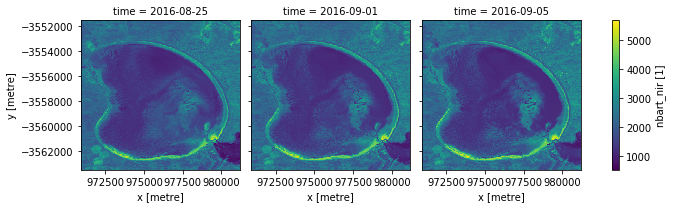

In [11]:
# New dates to interpolate data for
new_dates = ['2016-08-25', '2016-09-01', '2016-09-05']

# Interpolate Landsat values for three new dates
ds_interp = ds.interp(time=new_dates)

# Plot the new interpolated data
ds_interp.nbart_nir.plot(col='time')
plt.show()


## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [12]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)